In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns

In [2]:
loginDf = pd.read_json('logins.json')
loginDf.info()
loginDf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


# Part 1 ‑ Exploratory data analysis

In [3]:
df = pd.DataFrame(loginDf.groupby(pd.Grouper(freq='15T',key='login_time')).size().reset_index())
df.columns = ['login_time','login_counts']
df['month'] = df['login_time'].dt.month
df['hour'] = df['login_time'].dt.hour
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['day_of_week'] = df['login_time'].dt.dayofweek#.map(dayOfWeek)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 5 columns):
login_time      9788 non-null datetime64[ns]
login_counts    9788 non-null int64
month           9788 non-null int64
hour            9788 non-null int64
day_of_week     9788 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 382.4 KB


,login_time,login_counts,month,hour,day_of_week
0,1970-01-01 20:00:00,2,1,20,3
1,1970-01-01 20:15:00,6,1,20,3
2,1970-01-01 20:30:00,9,1,20,3
3,1970-01-01 20:45:00,7,1,20,3
4,1970-01-01 21:00:00,1,1,21,3


### Based on below plot, it seems that very early morning and late night has maximum logins. The login count decreases during daytime and afternoon with only increase around 11-12pm. And it starts increasing from post evening.

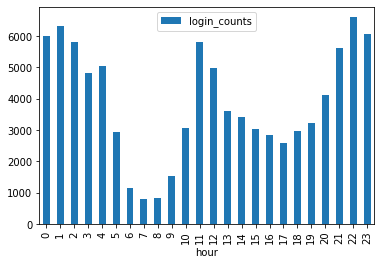

In [4]:
_ = df[['hour','login_counts']].groupby(['hour']).sum().plot(kind='bar')

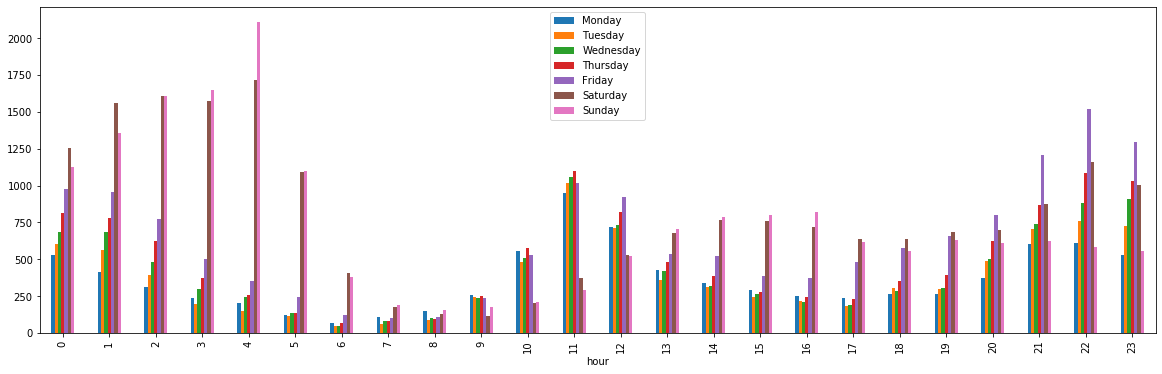

In [5]:
s = df[['hour','day_of_week','login_counts']].groupby([
    'hour','day_of_week']).sum().unstack('day_of_week').plot(kind='bar', figsize=(20,6))
_ = plt.legend(('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'), loc='upper center')

### As per below plot, the login counts increases during weekend.

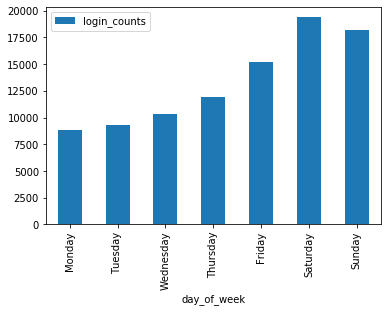

In [6]:
df[['day_of_week','login_counts']].groupby(['day_of_week']).sum().plot(kind='bar')
_ = plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

### Below plot shows that during month of March, the login count is more as compared to months January, February and April. Also, we can see that in each month, count is more during weekends.

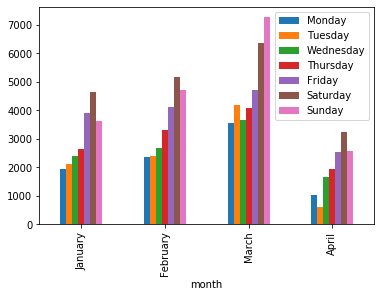

In [7]:
df[['day_of_week','month','login_counts']].groupby(['day_of_week','month']).sum().unstack('day_of_week').plot(kind='bar')
_ = plt.xticks([0,1,2,3],['January', 'February', 'March', 'April'])
_ = plt.legend(('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

# Part 2 ‑ Experiment and metrics design

#### Q: What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

__Answer:__
Since, during weekends both cities have reasonable activities, it would be better to perform the experiment during weekday. And weekday travel can justify proper success of the experiment.

Here, the mean of the sample proportion can be choosen as key metric. We can check, whether the mean of the total number of cars travelling from Gotham during day and similarly mean of the total number of cars travelling from Metropolis during night, increases after drivers start getting reimbursement of toll cost. 

It is easiest measure to keep track of, as this car will hault at the toll both and there the count of cars travel can be maintained.

__Q: Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:__

__a. how you will implement the experiment__

__b. what statistical test(s) you will conduct to verify the significance of the observation__

__c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.__

__Answer:__
For this hypothesis testing, we will consider significance level = 0.05.

__First hypothesis to check Gotham drivers:__
Ho = The mean of the cars travelling from Gotham during day time (i.e. around 6am to 6pm) remains same as before even after reimbursement process starts.
Ha = The mean of the cars travelling from Gotham during day time (i.e. around 6am to 6pm) increases as compared to that was earlier, after reimbursement process starts.

__Second hypothesis to check Metropolis drivers:__
Ho = The mean of the cars travelling from Metropolis during night time (i.e. around 7pm to 5am) remains same as before even after reimbursement process starts.
Ha = The mean of the cars travelling from Metropolis during day time (i.e. around 7pm to 5am) increases as compared to that was earlier, after reimbursement process starts.

Since, in our hypothesis testing, we just need to check if there is increase in the mean value after reimbursement process starts as compared to earlier value and we donot consider if it is equal or less than any value, we can perform one-tailed testing. 

If the p-value in both our hypothesis is less than 0.05, then we reject the null hypothesis. And the city operation can continue with the reimbursement process.
If the p-value in both the hypothesis is greater or equal to 0.05, then we fail to reject the null hypothesis and city operation has to come up with different experimentation.
Similarly, if we fail to reject even any one of the null hypothesis, then this experimentation is not fully successful and city operations have to come up with new plan.

# Part 3 ‑ Predictive modeling

In [8]:
import json
from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [9]:
with open('ultimate_data_challenge.json','r') as file:
    for line in file:
        data= json.loads(line)
        dataDf = pd.DataFrame(data)

dataDf.info()
dataDf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [10]:
dataDf.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [11]:
dataDf['avg_rating_by_driver'].fillna(dataDf['avg_rating_by_driver'].median(),inplace=True)
dataDf['avg_rating_of_driver'].fillna(dataDf['avg_rating_of_driver'].median(),inplace=True)
dataDf['ultimate_black_user'] = dataDf['ultimate_black_user'].map({False: 0, True: 1})
dataDf['last_trip_date'] = pd.to_datetime(dataDf['last_trip_date'])
dataDf['signup_date'] = pd.to_datetime(dataDf['signup_date'])
dataDf = dataDf.dropna()
dataDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49604 non-null float64
avg_rating_by_driver      49604 non-null float64
avg_rating_of_driver      49604 non-null float64
avg_surge                 49604 non-null float64
city                      49604 non-null object
last_trip_date            49604 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               49604 non-null datetime64[ns]
surge_pct                 49604 non-null float64
trips_in_first_30_days    49604 non-null int64
ultimate_black_user       49604 non-null int64
weekday_pct               49604 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.9+ MB


### Now, assuming data was taken after the latest trip was taken. So, based on the data the maximum value of the column 'last_trip_date' is 2014-07-01 and we need to check if user has taken any trip in preceding 30 days from this date. For all the records where the 'last_trip_date' value falls under this range, we will consider those as active users. Based on this, create a new column to identify active users which will be our dependent variable for model design.

In [12]:
day = dataDf['last_trip_date'].max() - timedelta(29)
dataDf['is_active'] = [1 if (x >= day) else 0 for x in dataDf['last_trip_date']]

### As per below pie-chart, fraction of the observed users which were retained is around 36.7%.

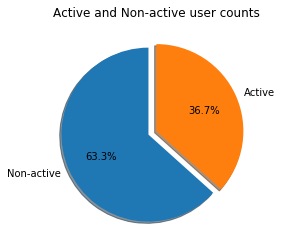

In [13]:
s = dataDf.groupby(['is_active']).size()#.plot(kind='bar')
labels = ['Non-active','Active']
explode = (0.1, 0) 
_ = plt.pie(s,explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
_ = plt.title('Active and Non-active user counts')

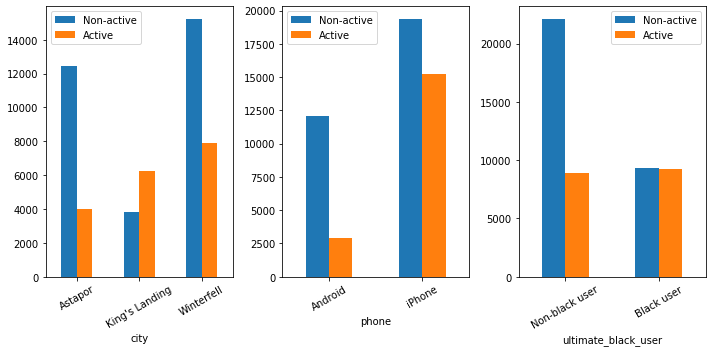

In [14]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=1,ncols=3,figsize=(10,5))
dataDf.groupby(['is_active','city']).size().unstack('is_active').plot(kind='bar',ax=ax1, rot=30)
_ = ax1.legend(('Non-active','Active'))
dataDf.groupby(['is_active','phone']).size().unstack('is_active').plot(kind='bar',ax=ax2, rot=30)
_ = ax2.legend(('Non-active','Active'))
dataDf.groupby(['is_active','ultimate_black_user']).size().unstack('is_active').plot(kind='bar',ax=ax3, rot=30)
_ = plt.xticks([0,1],['Non-black user', 'Black user'])
_ = ax3.legend(('Non-active','Active'))
_ = plt.tight_layout()

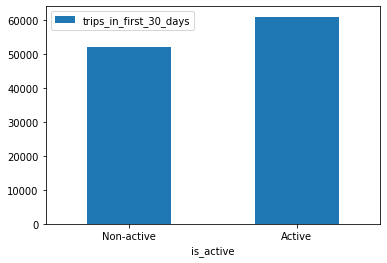

In [15]:
_ = dataDf[['is_active','trips_in_first_30_days']].groupby(['is_active']).sum().plot(kind='bar', rot=0)
_ = plt.xticks([0,1],['Non-active', 'Active'])

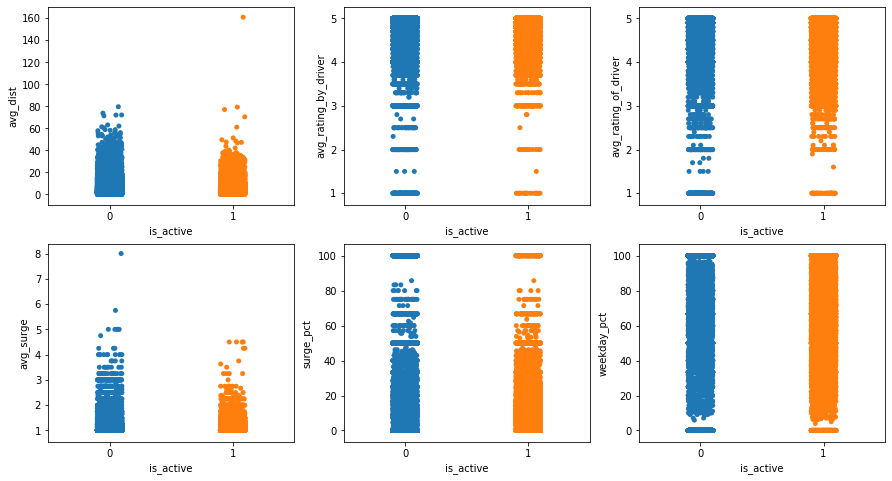

In [16]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(15,8))
sns.stripplot(x='is_active',y='avg_dist',data=dataDf,jitter=True,ax=ax[0][0])
sns.stripplot(x='is_active',y='avg_rating_by_driver',data=dataDf,jitter=True,ax=ax[0][1])
sns.stripplot(x='is_active',y='avg_rating_of_driver',data=dataDf,jitter=True,ax=ax[0][2])
sns.stripplot(x='is_active',y='avg_surge',data=dataDf,jitter=True,ax=ax[1][0])
sns.stripplot(x='is_active',y='surge_pct',data=dataDf,jitter=True,ax=ax[1][1])
sns.stripplot(x='is_active',y='weekday_pct',data=dataDf,jitter=True,ax=ax[1][2])

In [17]:
dataDf = pd.get_dummies(dataDf, columns = ['city','phone'])
X = dataDf.drop(['is_active','last_trip_date','signup_date'], axis = 1)
y = dataDf.is_active

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21, stratify= y)

In [18]:
rn = RandomForestClassifier(n_estimators=500)
model = rn.fit(X_train, y_train)
pred = model.predict(X_test)

print('Train accuracy: {}'.format(accuracy_score(model.predict(X_train), y_train)))
print('Test Accuracy: {}'.format(accuracy_score(y_test, pred)))
print('The confusion matrix is :')
print(confusion_matrix(y_test, pred))
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, pred)))
target_labels = ['Non-active', 'Active']
print('The classification report is :')
print(classification_report(y_test, pred, target_names=target_labels))

Train accuracy: 0.9973215828581303
Test Accuracy: 0.7578954441607311
The confusion matrix is :
[[7689 1739]
 [1864 3590]]
ROC AUC Score: 0.7368909585768363
The classification report is :
              precision    recall  f1-score   support

  Non-active       0.80      0.82      0.81      9428
      Active       0.67      0.66      0.67      5454

    accuracy                           0.76     14882
   macro avg       0.74      0.74      0.74     14882
weighted avg       0.76      0.76      0.76     14882



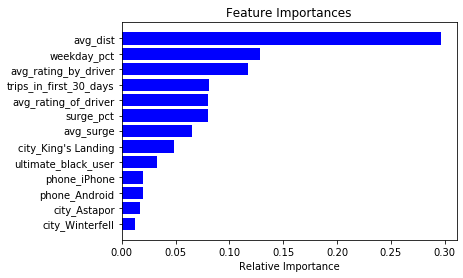

In [19]:
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [21]:
ratio = float(np.sum(y == 0) / np.sum(y==1))

XGModel = XGBClassifier(scale_pos_weight = ratio, learning_rate =0.2, n_estimators=500, max_depth=6, 
                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4, seed=27)

XGModel.fit(X_train,y_train)

y_XG_pred = XGModel.predict(X_test)

features = XGModel.feature_importances_
yg_pred_prob = XGModel.predict_proba(X_test)[:,1]

# Print the accuracy and other details.
print('Train accuracy: {}'.format(accuracy_score(XGModel.predict(X_train), y_train)))
print('Test accuracy: {}'.format(accuracy_score(y_XG_pred, y_test)))
print('The confusion matrix is :')
print(confusion_matrix(y_test, y_XG_pred))
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, y_XG_pred)))
target_labels = ['Non-active', 'Active']
print('The classification report is :')
print(classification_report(y_test, y_XG_pred, target_names=target_labels))

Train accuracy: 0.8824088474166235
Test accuracy: 0.7723424270931326
The confusion matrix is :
[[7491 1937]
 [1451 4003]]
ROC AUC Score: 0.7642524417199181
The classification report is :
              precision    recall  f1-score   support

  Non-active       0.84      0.79      0.82      9428
      Active       0.67      0.73      0.70      5454

    accuracy                           0.77     14882
   macro avg       0.76      0.76      0.76     14882
weighted avg       0.78      0.77      0.77     14882



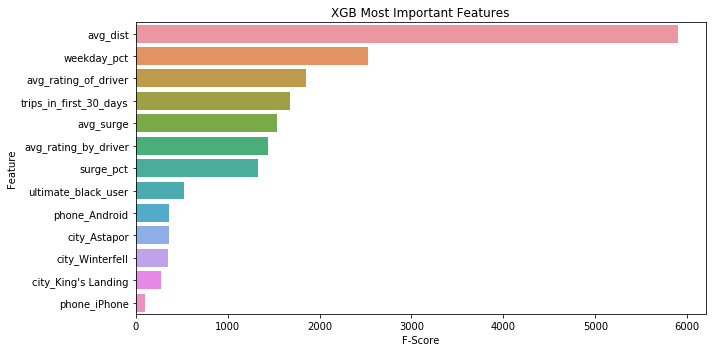

In [22]:
featureDict = XGModel.get_booster().get_fscore()
s = pd.DataFrame.from_dict(featureDict,orient='index').reset_index()
s.columns=['Feature','F-Score']
plt.figure(figsize=(10,5))
sns.barplot(x='F-Score', y='Feature', data=s.sort_values(by='F-Score', ascending=False).iloc[:50])
plt.title('XGB Most Important Features')
plt.tight_layout()

### Since, this is binary clssification problem, RandomForestClassifier ensemble model is executed to get the feature details. Also, implemented XGBoostClassifier model, to cross validate the feature importance obtained from RandomForestClassifier. XGBoostClassifier has better test accuracy (77.23%) as well as ROC_AUC score (0.764). Based on both the models implemented, users who have travelled more average distance in miles per trip in the first 30 days after signup are more likely to retain. Also, users who are travelling more during weekdays are likely to be more active users.